In [1]:
# generate document vectors or word vectors (embeddings)
# you'll need a word embeddings on all the data for modeling
# then make word embeddings for each star category
# these embeddings should be used to compare 'word' similarities 
# pass a word like 'beer' or 'fish and chips' or 'fish' or 'burger' and look at 'most_similar' or pass in ['good', 'burger']

# make tfidf for each star rating and compare 'important' words across those ratings
# then compare stop words

# Question: How can we leverage yelp data to give us insights on our business? 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re
import gensim
import string
import time

# Read Data Files

### Import Business Info CSV file

In [3]:
business_info_df = pd.read_csv("business_info_all.csv", encoding = "ISO-8859-1")
print(business_info_df.shape)
business_info_df.head()

(1081, 9)


,address,biz_id,category,image_shown,name,num_reviews,price_range,star_rating,url
0,234 Western Ave,the-cuckoos-nest-albany,"['Southern', 'American New']",https://s3-media1.fl.yelpcdn.com/bphoto/6ZAVl7...,The CuckooÃ¢ÂÂs Nest,235.0,$$,4.5,https://www.yelp.com/biz/the-cuckoos-nest-alba...
1,79 N Pearl St,the-hollow-bar-and-kitchen-albany,"['American New', 'Music Venues', 'Venues & Eve...",https://s3-media4.fl.yelpcdn.com/bphoto/XjDwO1...,The Hollow Bar & Kitchen,304.0,$$,4.0,https://www.yelp.com/biz/the-hollow-bar-and-ki...
2,182A Washington Ave,iron-gate-cafe-albany,['Cafes'],https://s3-media3.fl.yelpcdn.com/bphoto/A01kLn...,Iron Gate Cafe,474.0,$$,4.5,https://www.yelp.com/biz/iron-gate-cafe-albany...
3,281 New Scotland Ave,the-albany-ale-and-oyster-albany,"['American Traditional', 'Beer Bar']",https://s3-media3.fl.yelpcdn.com/bphoto/H-GObC...,The Albany Ale & Oyster,240.0,$$,4.5,https://www.yelp.com/biz/the-albany-ale-and-oy...
4,109 Wolf Rd,kuma-ani-albany-4,['Ramen'],https://s3-media2.fl.yelpcdn.com/bphoto/ZX6doy...,Kuma Ani,22.0,NaN,4.5,https://www.yelp.com/biz/kuma-ani-albany-4?osq...


In [4]:
business_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 9 columns):
address        1036 non-null object
biz_id         1081 non-null object
category       1081 non-null object
image_shown    1081 non-null object
name           1081 non-null object
num_reviews    1081 non-null float64
price_range    874 non-null object
star_rating    1081 non-null float64
url            1081 non-null object
dtypes: float64(2), object(7)
memory usage: 76.1+ KB


In [5]:
#Business categories are stores as one string. Need to convert to a list of strings.
import ast
business_info_df.category = business_info_df.category.map(ast.literal_eval)

### Import All Reviews CSV file

In [6]:
reviews_df = pd.read_csv("reviews_all.csv")
reviews_df.date = pd.to_datetime(reviews_df.date)
print(reviews_df.shape)
reviews_df.head()

(59274, 8)


,business_index,business_name,date,pic_count,pic_urls,review,star_rating,user_id
0,the-cuckoos-nest-albany,The Cuckoo’s Nest,2019-07-22,0,[],"#GRITS know best! So take it from this one, th...",5.0,NaN
1,the-cuckoos-nest-albany,The Cuckoo’s Nest,2019-08-13,0,[],Brunch was enjoyable from the mimosa starter t...,4.0,NaN
2,the-cuckoos-nest-albany,The Cuckoo’s Nest,2019-06-28,3,['https://s3-media2.fl.yelpcdn.com/bphoto/Jiq3...,If you're looking for a delicious meal on a la...,5.0,JakQRw_9dW-j5kJchUf2OQ
3,the-cuckoos-nest-albany,The Cuckoo’s Nest,2019-04-26,3,['https://s3-media3.fl.yelpcdn.com/bphoto/11Wc...,The best way I can describe this place is wit...,5.0,MVIlQinGxgwPH_XOUpoXrA
4,the-cuckoos-nest-albany,The Cuckoo’s Nest,2019-08-30,0,[],Had dinner here last night and I'm still think...,5.0,NaN


Print a random review:

In [7]:
#Print random review:

idx = np.random.randint(0,len(reviews_df))
print("NAME:",reviews_df.business_name[idx])
print("RATING:",reviews_df.star_rating[idx],"stars")
print("DATE:",reviews_df.date[idx].date())
print(reviews_df.review[idx])

NAME: T-Swirl Crepe
RATING: 3.0 stars
DATE: 2019-01-29
Yelps 3 stars is "A-OK" and I think that sums T-Swirl up well. Everything you get is what they claim it will be. They didn't underperform. The shortfalls were more functional.The crepes are pretty small, so eating for a family isn't really a full meal, yet it still costs what a full meal does. The crepes, particularly if you get a savory one with veggies and meat, are very difficult to eat, it makes a total mess. The sweet crepe I got, banana Nutella, wasn't warm, which although they never said it would be, it feels like it should be. All that said, the crepes were flavorful and tasted great. I got an earl grey milk tea it was extremely good, however they kept forgetting about it and I had to go up and ask 3 times. We ate our whole meal and waited some more before my tea was ready. I think this would be a really fun place to take little kiddies for a snack or dessert, I would maybe skip it for dinner.


In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59274 entries, 0 to 59273
Data columns (total 8 columns):
business_index    59274 non-null object
business_name     59274 non-null object
date              59274 non-null datetime64[ns]
pic_count         59274 non-null int64
pic_urls          59274 non-null object
review            59274 non-null object
star_rating       59274 non-null float64
user_id           11699 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.6+ MB


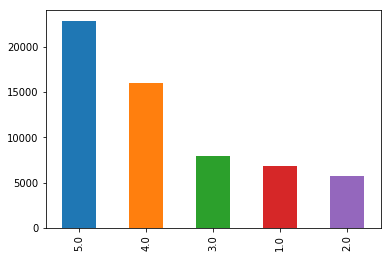

In [9]:
reviews_df.star_rating.value_counts().plot(kind='bar')

#### See all Categories represented

In [10]:
#categories = [item for sublist in l for item in sublist]
flat_list = []
for sublist in business_info_df.category:
    for item in sublist:
        flat_list.append(item)

categories = list(set(flat_list))
print(len(categories), "unique categories")

157 unique categories


### Import IDF CSV file

In [11]:
idf_df = pd.read_csv("idf.csv")
idf_df.head()

,word,idf_weight,in_nltk_stopwds
0,the,0.095746,True
1,and,0.113673,True
2,a,0.242181,True
3,to,0.339277,True
4,i,0.362738,True


Store desired stopwords from IDF weighted words

In [12]:
#Top n words in IDF
n = 100

idf_stopwords_list = list(idf_df.sort_values(by=['idf_weight'])[0:n]['word'])

In [13]:
print(idf_stopwords_list)

['the', 'and', 'a', 'to', 'i', 'of', 'was', 'for', 'is', 'in', 'it', 'food', 'but', 'with', 'this', 'my', 'on', 'good', 'that', 'they', 'had', 'not', 'have', 'place', 'were', 'we', 'you', 'are', 'great', 'be', 'so', 'at', 'very', 'service', 'here', 'as', 'there', 'out', 'if', 'all', 'like', 'just', 'back', 'time', 'from', 'one', 'go', 'or', 'when', 'get', 'their', 'an', 'which', 'would', 'our', 'will', "it's", 'me', 'up', 'ordered', 'been', 'also', 'really', 'some', 'delicious', 'about', 'more', 'what', 'restaurant', 'only', 'nice', 'chicken', 'menu', 'best', 'no', 'order', 'well', 'can', 'by', 'friendly', 'too', 'other', 'staff', 'got', "don't", 'has', 'even', "i've", 'try', 'because', 'came', 'your', 'little', 'than', 'always', 'us', "i'm", 'them', 'after', 'definitely']


Combine with NLTK English Stopwords

In [14]:
stopwords = list(set(nltk.corpus.stopwords.words('english') + idf_stopwords_list))

In [15]:
#Remove any stopwords using the list below
stopwords_to_remove = ["food","chicken","service","friendly","delicious","restaurant","menu","best",
                       "order","staff","good","great"]

for remove in stopwords_to_remove:
    stopwords.remove(remove)

In [16]:
print(stopwords)

['about', 'our', 'ma', 'will', 'to', 'from', 'one', 'off', 'down', 'who', "wouldn't", 't', "needn't", 'my', 'it', 'other', "you've", 'don', 'didn', 'himself', 'yourself', 'hadn', 'shan', 'have', 'during', 'also', 'only', 'under', 'the', 'back', 'shouldn', 'ours', 'through', 'been', 'couldn', 'ordered', 'few', "haven't", 'both', 'her', 'does', 'herself', 'ourselves', 'isn', "i'm", 'such', 'now', 'as', 'until', 'those', 'if', 'am', 'yours', 'what', 'why', 'each', 'mustn', 're', "didn't", 'won', 'or', 'you', 'aren', 'more', 'no', 'needn', 'he', 'like', 'got', 'is', 'y', 'a', 'than', 'very', 'them', 'over', "wasn't", 'they', 'me', "shan't", 'us', 'doesn', "you'd", 'because', 'do', 'of', 'then', 'these', 'in', "won't", 'go', 'but', 'she', 'd', "mustn't", 'yourselves', 'before', 'any', "shouldn't", 'wasn', 'i', 'above', 'while', 'so', 'and', 'up', "aren't", 'great', 'its', 'with', 'hers', 'an', 'were', 'wouldn', 'all', 'doing', 'which', 'nor', 'when', "hasn't", 'get', 'again', 'just', 'weren

In [58]:
"more" in stopwords

True

## Define helper functions for selecting data from dataframes

- get_businesses_by_category(chosen_category)
- get_reviews_by_category(chosen_category)
- get_reviews_for_businesses(biz_id_list)

In [17]:
import re

def get_businesses_by_category(chosen_category):
    """
    This function returns all businesses in business_info_df for a particular category.
    Substrings of categories will also find the selected category.
    INPUTS:
    chosen_category = text string to match against category list in business_info_df category feature.
    OUTPUT:
    business_info_df selection based on chosen category.
    """
    chosen_category = chosen_category.lower()
    #Check if it is a substring also
    return business_info_df[ 
        [True in [bool(re.search(chosen_category, category.lower())) for category in category_list] 
         for category_list in business_info_df.category] ]
    #return business_info_df[[chosen_category in category for category in business_info_df.category]]

def get_reviews_by_category(chosen_category):
    """
    This function returns all reviews for a particular category.
    INPUTS:
    chosen_category = text string to match against category list in business_info_df category feature.
    OUTPUT:
    reviews_df selection based on chosen category.
    """
    #Select businesses
    biz_ids_for_category = get_businesses_by_category(chosen_category)['biz_id']
    #Select Reviews for businesses
    return reviews_df[[biz_id in biz_ids_for_category.values for biz_id in reviews_df.business_index.values]]

In [18]:
def get_businesses_by_name(search_name):
    """
    This function returns all businesses in business_info_df for a business name.
    Substrings of business name will also find the selected businesses.
    INPUTS:
    search_name = text string to match against business name in business_info_df.
    OUTPUT:
    business_info_df selection based on chosen search name.    
    """
    search_name = search_name.lower()
    #Check if it is a substring also
    return business_info_df[ 
        [bool(re.search(search_name, biz_name.lower())) for biz_name in business_info_df.name] ] 

In [19]:
def get_reviews_for_businesses(biz_id_list):
    """
    This function returns all reviews for a list of business_index's.
    INPUTS:
    biz_id_list = list of text strings representing business indexes to select reviews on.
    OUTPUT:
    reviews_df selection based on chosen businesses.
    """
    return reviews_df[[biz_id in biz_id_list for biz_id in reviews_df.business_index.values]]

Downselecting categories based on number of businesses and number of reviews

In [20]:
min_businesses = 5
min_reviews = 1500

category_list = []
biz_list = []

for category in categories:
    businesses = get_businesses_by_category(category)['biz_id'].values
    num_businesses = len(businesses)
    num_reviews = len(get_reviews_by_category(category))
    if num_businesses > min_businesses and num_reviews > min_reviews:
        tabs = "\t"
        if (len(category) < 7):
            tabs = "\t\t"
        print(category, tabs, num_businesses, "places,\t", num_reviews,"reviews")
        category_list.append(category)
        biz_list.extend(businesses)
        
biz_list = list(set(biz_list))
print(len(biz_list),"unique businesses represented in these categories.")
print(len(get_reviews_for_businesses(biz_list)),"unique reviews represented in these categories.")

Pizza 		 145 places,	 6039 reviews
Cafes 		 47 places,	 2313 reviews
Salad 		 62 places,	 3289 reviews
Sandwiches 	 127 places,	 5393 reviews
Steakhouses 	 21 places,	 2146 reviews
Barbeque 	 21 places,	 1685 reviews
Asian Fusion 	 20 places,	 1689 reviews
Burgers 	 124 places,	 5478 reviews
Coffee & Tea 	 53 places,	 1891 reviews
Sushi Bars 	 37 places,	 3304 reviews
Pubs 		 53 places,	 4409 reviews
Mexican 	 37 places,	 2684 reviews
Bars 		 156 places,	 11303 reviews
Italian 	 97 places,	 6212 reviews
Mediterranean 	 17 places,	 1589 reviews
Chicken Wings 	 44 places,	 1676 reviews
Thai 		 25 places,	 1876 reviews
American Traditional 	 172 places,	 10495 reviews
Fast Food 	 92 places,	 2088 reviews
Indian 		 26 places,	 1873 reviews
Delis 		 64 places,	 1891 reviews
Breakfast & Brunch 	 103 places,	 6032 reviews
American New 	 75 places,	 5754 reviews
Seafood 	 38 places,	 3769 reviews
Cocktail Bars 	 18 places,	 1538 reviews
Diners 		 36 places,	 2054 reviews
Japanese 	 35 places,	

In [21]:
category = 'wine'
num_businesses = len(get_businesses_by_category(category))
num_reviews = len(get_reviews_by_category(category))
print(category, "\t", num_businesses, "places,\t", num_reviews,"reviews")

wine 	 15 places,	 837 reviews


In [22]:
get_businesses_by_category('wine')[0:5]

,address,biz_id,category,image_shown,name,num_reviews,price_range,star_rating,url
13,200 Lark St,p%C5%8Dst-albany,"[Tapas/Small Plates, Wine Bars]",https://s3-media2.fl.yelpcdn.com/bphoto/IDmb8D...,PÃ Âst,26.0,NaN,4.5,https://www.yelp.com/biz/p%C5%8Dst-albany?osq=...
25,288 Lark St,288-lark-wine-and-tap-albany,"[Italian, Wine Bars]",https://s3-media1.fl.yelpcdn.com/bphoto/V9UQKq...,288 Lark Wine & Tap,10.0,NaN,4.5,https://www.yelp.com/biz/288-lark-wine-and-tap...
38,540 Delaware Ave,the-cheese-traveler-albany,"[Cheese Shops, Sandwiches, Beer, Wine & Spirits]",https://s3-media4.fl.yelpcdn.com/bphoto/4yxn6B...,The Cheese Traveler,153.0,$$,5.0,https://www.yelp.com/biz/the-cheese-traveler-a...
47,897 Broadway,vintage-house-albany-3,"[Tapas/Small Plates, Wine Bars]",https://s3-media4.fl.yelpcdn.com/bphoto/YAkHnL...,Vintage House,59.0,$$,4.0,https://www.yelp.com/biz/vintage-house-albany-...
153,NaN,provence-restaurant-and-wine-bar-albany,"[French, Mediterranean, Wine Bars]",https://s3-media4.fl.yelpcdn.com/bphoto/D7K6AT...,Provence Restaurant & Wine Bar,115.0,$$$,3.0,https://www.yelp.com/biz/provence-restaurant-a...


# Clean Text Function
Define function to clean text blocks.

In [23]:
# string.punctuation contains '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

def clean_text(text_block):
    """
    This function cleans a block of text.
    INPUT:
    text_block = The block of text to clean.
    OUTPUT:
    A block of text stripped of punctuation and made lowercase.
    """
    #Some reviews forget to have a space after a period. I want to force a space.
    #text_block = text_block.replace("."," ")
    #This represents a non-breaking space in the text block that needs to be removed.
    text_block = text_block.replace(u'\xa0', u' ')
    text_block = text_block.replace('&',' and ')
    text_block = text_block.replace('%',' percent ')
    #for symbol in ",.?!''\n":
    for symbol in '!"#$()*+,-./:;<=>?@[\\]^_`{|}~':
        text_block = text_block.replace(symbol, ' ').lower()
    text_block = re.sub(' +', ' ', text_block)
    return text_block

In [24]:
clean_text(reviews_df.review[0])

" grits know best so take it from this one this is some delicious southern food i ordered the fried chicken with corn bread and mac cheese for my fixins yes i said it fixins just like their menu says the cornbread was huge and buttery the fried very well seasoned with a hit of lemon which i loved the mac cheese wasn't the best i have ever had but best i have had in this area so far just wished i had a few burnt edges lol my friend had the blackened catfish and it was equally delicious their services was quite friendly our waitress wasn't as efficient and was a bit slow but the hostess made up for it her friendliness over compensated and made it a very pleasant experience the only criticism i have would be with the drinks as it seemed they packed the cups with ice before filling with the liquid that tends to annoy me a bit as it will water down your drink as the ice melts so i proceeded to take out all the ice and the hostess noticed and filled up the cup kudosoverall it was quite a nic

In [25]:
reviews_df.review[0]

'#GRITS know best! So take it from this one, this is some delicious Southern food! I ordered the fried chicken with corn bread and mac/cheese for my fixins! Yes! I said it "fixins" just like their menu says. The cornbread was HUGE and buttery. The fried very well seasoned with a hit of lemon which I LOVED. The mac/cheese wasn\'t the best I have ever had but best I have had in this area so far, just wished I had a few burnt edges lol My friend had the blackened catfish and it was equally delicious! Their services was quite friendly! Our waitress wasn\'t as efficient and was a bit slow but the hostess made up for it! Her friendliness over compensated and made it a very pleasant experience. The only criticism I have would be with the drinks as it seemed they packed the cups with ice before filling with the liquid. That tends to annoy me a bit as it will water down your drink as the ice melts. So I proceeded to take out all the ice and the hostess noticed and filled up the cup! #kudosOvera

# Tokenize Text Function
Define function to tokenize text blocks.

In [26]:
#Declare default tokenizer method and stopwords list that will be used in the my_tokenizer() method.
default_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False).tokenize

def my_tokenizer(text_block,  
                 tokenizer=default_tokenizer):
    """
    This function cleans a block of text using the clean_text() function and then
    tokenizes the cleaned block of text.
    
    INPUTS:
    text_block = The text string to be tokenized.
    tokenizer  = The tokenizer method to use for splitting the text string into tokens. 
                 Default is default_tokenizer defined outside of this function.
    OUTPUT:
    List of words in the text block.
    """
    tokens = tokenizer(clean_text(text_block))
    return tokens

# Remove Stopwords Function
Define function to remove stopwords.

In [27]:
def remove_stopwords(text, stopwords=stopwords):
    
    #If text is a list, assume tokenized.
    if type(text) is list:
        return [token for token in text if token not in stopwords]
    
    #If type is string, not tokenized.
    elif type(text) is str:
        words = text.split()
        resultwords  = [word for word in words if word.lower() not in stopwords]
        result = ' '.join(resultwords)
        return result
    
    #Print error message
    print("BAD FORMAT")
    return

Testing below

In [28]:
cleaned = clean_text(reviews_df.review[0])
print(remove_stopwords(cleaned))

grits know best take delicious southern food fried chicken corn bread mac cheese fixins yes said fixins menu says cornbread huge buttery fried seasoned hit lemon loved mac cheese best ever best area far wished burnt edges lol friend blackened catfish equally delicious services quite friendly waitress efficient bit slow hostess made friendliness compensated made pleasant experience criticism drinks seemed packed cups ice filling liquid tends annoy bit water drink ice melts proceeded take ice hostess noticed filled cup kudosoverall quite experience i'll oh hostess gave homemade biscuits delicious plate sorry


In [29]:
tokenized = my_tokenizer(reviews_df.review[0])
print(remove_stopwords(tokenized))

['grits', 'know', 'best', 'take', 'delicious', 'southern', 'food', 'fried', 'chicken', 'corn', 'bread', 'mac', 'cheese', 'fixins', 'yes', 'said', 'fixins', 'menu', 'says', 'cornbread', 'huge', 'buttery', 'fried', 'seasoned', 'hit', 'lemon', 'loved', 'mac', 'cheese', 'best', 'ever', 'best', 'area', 'far', 'wished', 'burnt', 'edges', 'lol', 'friend', 'blackened', 'catfish', 'equally', 'delicious', 'services', 'quite', 'friendly', 'waitress', 'efficient', 'bit', 'slow', 'hostess', 'made', 'friendliness', 'compensated', 'made', 'pleasant', 'experience', 'criticism', 'drinks', 'seemed', 'packed', 'cups', 'ice', 'filling', 'liquid', 'tends', 'annoy', 'bit', 'water', 'drink', 'ice', 'melts', 'proceeded', 'take', 'ice', 'hostess', 'noticed', 'filled', 'cup', 'kudosoverall', 'quite', 'experience', "i'll", 'oh', 'hostess', 'gave', 'homemade', 'biscuits', 'delicious', 'plate', 'sorry']


# Word Embedding

In [30]:
import nltk
import gensim
import string
import time

#### Tokenize each review

In [31]:
print("Tokenizing Reviews: ", end='')
start = time.time()

data_tokenized = reviews_df.review.map(my_tokenizer).values

end = time.time()
print(round(end-start,2))

Tokenizing Reviews: 31.0


#### Remove Stopwords

In [32]:
print("Removing Stopwords: ", end='')
start = time.time()

data_stopped = list(map(remove_stopwords, data_tokenized))

end = time.time()
print(round(end-start,2))

Removing Stopwords: 13.04


In [33]:
idx = 0
print(reviews_df.review[idx])
print("")
print(data_stopped[idx])

#GRITS know best! So take it from this one, this is some delicious Southern food! I ordered the fried chicken with corn bread and mac/cheese for my fixins! Yes! I said it "fixins" just like their menu says. The cornbread was HUGE and buttery. The fried very well seasoned with a hit of lemon which I LOVED. The mac/cheese wasn't the best I have ever had but best I have had in this area so far, just wished I had a few burnt edges lol My friend had the blackened catfish and it was equally delicious! Their services was quite friendly! Our waitress wasn't as efficient and was a bit slow but the hostess made up for it! Her friendliness over compensated and made it a very pleasant experience. The only criticism I have would be with the drinks as it seemed they packed the cups with ice before filling with the liquid. That tends to annoy me a bit as it will water down your drink as the ice melts. So I proceeded to take out all the ice and the hostess noticed and filled up the cup! #kudosOverall,

#### Gensim Phrasing

In [34]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [35]:
#Choose to implement phraser before or after removing stopwords

#IF FALSE, text is phrased and then stopped
#IF TRUE, text is stopped and then phrased
phrase_after_stopping = True

In [36]:
#Set appropriate version of data to be phrased - stopped or not yet stopped
if phrase_after_stopping:
    data_to_phrase = data_stopped
else:
    data_to_phrase = data_tokenized

#Run through phrasing
print("Bigram Phraser:     ", end='')
start = time.time()
bigram = Phrases(sentences=data_tokenized, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram)
end = time.time()
print(round(end-start,2))

print("Bigram Tokenizing:  ", end='')
start = time.time()
bigram_tokenized = [bigram_phraser[review] for review in data_to_phrase]
end = time.time()
print(round(end-start,2))

print("Trigram Phraser:    ", end='')
start = time.time()
trigram = Phrases(sentences=bigram_tokenized, min_count=5, threshold=10)
trigram_phraser = Phraser(trigram)
end = time.time()
print(round(end-start,2))

print("Trigram Tokenizing: ", end='')
start = time.time()
data = [trigram_phraser[review] for review in bigram_tokenized]
end = time.time()
print(round(end-start,2))

if phrase_after_stopping == False:
    data = list(map(remove_stopwords, data))

Bigram Phraser:     24.5
Bigram Tokenizing:  8.79
Trigram Phraser:    27.47
Trigram Tokenizing: 8.67


In [37]:
#Store tokenized reviews in the reviews_df
reviews_df['review_tokenized'] = data

#Save tokenized data back to csv file
reviews_df.to_csv('reviews_all_tokenized.csv',index=False)

In [38]:
#Viewing output of phraser for an example review
print(data[39])

['service', 'delicious', 'cocktails', 'albeit_bit', 'overpriced', 'opinion', 'others', 'said', 'biggest', 'bang_buck', "cuckoo's_nest", 'makes', 'environment', 'excellent', 'service', 'menu', 'indulge', 'biscuits', 'honey', 'small', 'delicious', 'deviled_eggs', 'tasty', 'start', 'fried_chicken', 'reason_giving', '5_star_review', 'picky', 'fried_chicken', 'though', 'necessarily', 'recommend', 'people', 'specifically', 'fried_chicken', 'worth_visit']


In [39]:
for review in data[0:100]:
    has_trigram = False
    for word in review:
        if word.count('_')>=2:
            has_trigram = True
            print(word)
    if has_trigram:
        print(review, "\n")

new_world_bistro
['brunch', 'enjoyable', 'mimosa', 'starter', 'eggs_benedict', 'coffee', 'service_prompt', 'direct', 'outside_seating', 'sunny_day', 'ghetto', 'elements', 'deal', 'beaker', 'ghetto', 'roamers', 'feel_need', 'broadcast', 'conversations', 'streetside', 'yelling', 'others', 'public', 'intrusive', 'enjoying', 'summer_day', 'crowd_young', 'professional', 'set', 'sprinkled', 'families', 'college_students', 'paying', "can't_comment", 'price', 'nearby', 'madison_cafe', 'new_world_bistro', 'brunch', "let's", 'see', "they're", 'consistent'] 

sat_outside_patio
served_piping_hot
['looking', 'delicious', 'meal', 'lazy', 'sunday_morning', "cuckoo's_nest", 'covered', 'brief', 'glimpse', 'interior', 'restaurant', 'intimate', 'cozy', 'space', 'exactly_want', 'brunch', 'friends', 'day', 'went', 'weather', 'outside', 'balmy', '75', 'boyfriend', 'friend', 'sat_outside_patio', 'charming', 'welcoming', 'bright', 'spring', 'flowers', 'organized', 'sufficient', 'room', 'adjacent', 'tables', '

In [40]:
total_vocabulary = set(word for review in data for word in review)
print("There are {} unique tokens in the dataset.".format(len(total_vocabulary)))

There are 64422 unique tokens in the dataset.


## Generate Word Embeddings

In [41]:
print("Generate Word Vectors: ", end='')
start = time.time()
model = gensim.models.Word2Vec(data,size=100,window=5,min_count=1,workers=4)
model.train(data,total_examples=model.corpus_count,epochs=10)
end = time.time()
print(round(end-start,2),"seconds")

Generate Word Vectors: 39.41 seconds


In [42]:
#Save embedded word vector space
wv = model.wv
print("Corpus Count:",model.corpus_count)

Corpus Count: 59274


In [43]:
#Explore the word vector space
wv.most_similar(positive=['vegetarian','burger'],negative=['italian'])

[('veggie_burger', 0.6146519780158997),
 ('sliders', 0.5585982203483582),
 ('slider', 0.5571416020393372),
 ('burgers', 0.5485298037528992),
 ('turkey_burger', 0.5326671600341797),
 ('tempeh', 0.5229963064193726),
 ('burger_fries', 0.5070376992225647),
 ('bun', 0.5058655738830566),
 ('red_meat', 0.4739683270454407),
 ('pescatarian', 0.4613233804702759)]

# Dividing Reviews based on Star Rating

Create a dictionary `reviews` containing the reviews with the star ratings as keys.

create a dictionary `models` containing word embedding models for each star rating.

In [44]:
ratings = reviews_df.star_rating.unique()
reviews = {}
models = {}

for rating in ratings:
    print(f"Modeling {rating} rating: ", end='')
    start = time.time()
    reviews[rating] = reviews_df.review_tokenized[reviews_df.star_rating==rating]
    models[rating] = gensim.models.Word2Vec(reviews[rating],size=100,window=5,min_count=1,workers=4)
    models[rating].train(reviews[rating],total_examples=models[rating].corpus_count,epochs=10)
    end = time.time()
    print(round(end-start,2))

Modeling 5.0 rating: 12.22
Modeling 4.0 rating: 11.52
Modeling 1.0 rating: 5.25
Modeling 3.0 rating: 7.12
Modeling 2.0 rating: 4.91


In [45]:
#See outputs for a specific word
positive = ['tasty', 'beer']
negative = []
n_words = 6
for key in sorted(models, reverse=True):
    try:
        print(key,"rating",[w[0] for w in models[key].wv.most_similar(
            positive=positive, negative=negative, topn=n_words)])
    except:
        pass

5.0 rating ['samplers', 'kirin', 'singha', 'habanaro', 'served_ice_cold', 'pupu']
4.0 rating ['pretzels', 'tequila', 'hoppy', 'chalula', 'margarita', 'lemon_pepper_garlic']
3.0 rating ['safer', 'demands', 'cheese_pretzels', 'dew', 'poor_excuse', 'advocado']
2.0 rating ['typical_pub_fare', 'noisey', 'fits_bill', 'bacardi', 'bacon_wrapped_filet', 'miso_soup_salad']
1.0 rating ['cosmo', 'selection', 'minimalfood', 'limited_menu', 'refreshing', 'unshaken']


# Dividing Reviews based on Category

Create a dictionary `category_models` containing word embedding models for each category.

In [46]:
#Dictionary of category keys. Each item is a dictionary of models by star rating.
category_models = {}

print("Modeling:")
start = time.time()

for category in category_list:
    reviews = get_reviews_by_category(category)
    print(f"{category}\t({len(reviews)}) reviews,", end=' ')
    #reviews_df.review_tokenized[reviews_df.star_rating==rating]
    ratings = reviews.star_rating.unique()
    rating_models = {}
    for rating in ratings:
        selected_reviews = reviews.review_tokenized[reviews.star_rating==rating]
        print(f"{rating}*({len(selected_reviews)})", end=' ')
        rating_models[rating] = gensim.models.Word2Vec(selected_reviews,size=100,window=5,min_count=1,workers=4)
        rating_models[rating].train(selected_reviews,total_examples=rating_models[rating].corpus_count,epochs=10)
    #category_models[category] = gensim.models.Word2Vec(reviews['review_tokenized'],size=100,window=5,min_count=1,workers=4)
    #category_models[category].train(reviews['review_tokenized'],total_examples=category_models[category].corpus_count,epochs=10)
    category_models[category] = rating_models
    print("")
end = time.time()
print(f"{round(end-start,2)} seconds")

Modeling:
Pizza	(6039) reviews, 5.0*(2100) 3.0*(798) 2.0*(624) 4.0*(1567) 1.0*(950) 
Cafes	(2313) reviews, 5.0*(1138) 4.0*(632) 3.0*(242) 2.0*(145) 1.0*(156) 
Salad	(3289) reviews, 5.0*(1344) 4.0*(928) 1.0*(337) 3.0*(392) 2.0*(288) 
Sandwiches	(5393) reviews, 5.0*(2402) 4.0*(1366) 1.0*(497) 3.0*(666) 2.0*(462) 
Steakhouses	(2146) reviews, 5.0*(715) 4.0*(561) 2.0*(284) 3.0*(346) 1.0*(240) 
Barbeque	(1685) reviews, 4.0*(447) 5.0*(588) 3.0*(256) 1.0*(193) 2.0*(201) 
Asian Fusion	(1689) reviews, 5.0*(722) 3.0*(210) 4.0*(471) 2.0*(148) 1.0*(138) 
Burgers	(5478) reviews, 5.0*(1716) 4.0*(1324) 2.0*(645) 3.0*(805) 1.0*(988) 
Coffee & Tea	(1891) reviews, 5.0*(629) 3.0*(236) 2.0*(209) 4.0*(484) 1.0*(333) 
Sushi Bars	(3304) reviews, 5.0*(1332) 4.0*(929) 3.0*(437) 2.0*(287) 1.0*(319) 
Pubs	(4409) reviews, 5.0*(1592) 4.0*(1394) 1.0*(442) 3.0*(599) 2.0*(382) 
Mexican	(2684) reviews, 4.0*(675) 5.0*(668) 1.0*(488) 3.0*(436) 2.0*(417) 
Bars	(11303) reviews, 5.0*(4244) 4.0*(3049) 1.0*(1244) 3.0*(1630) 2

In [47]:
#See outputs for a specific word and category
positive = ['tasty','food']
negative = []
category_list = ['Salad', 'Japanese', 'Breakfast & Brunch', 'Barbeque', 'Italian', 'Pubs']
n_words = 6
for cat in category_list:
    print(cat)
    for key in sorted(category_models[cat].keys(), reverse=True):
        try:
            print(key,"rating",[w[0] for w in category_models[cat][key].wv.most_similar(
                positive=positive, negative=negative, topn=n_words)])
        except:
            pass
    print("")

Salad
5.0 rating ['clean', 'attentive', 'fantastic', 'wonderful', 'outstanding', 'staff']
4.0 rating ['staff', 'quality', 'atmosphere', 'prices', 'excellent', 'amazing']
3.0 rating ['though', 'menu', 'restaurant', 'bit', 'pretty', 'pizza']
2.0 rating ['menu', 'chicken', 'pizza', 'make', 'ramen', 'salad']
1.0 rating ['make', 'thing', 'restaurant', 'chicken', 'left', 'walked']

Japanese
5.0 rating ['fantastic', 'amazing', 'presentation', 'clean', 'attentive', 'outstanding']
4.0 rating ['delicious', 'everything', 'though', 'prepared', 'clean', 'wasabi']
3.0 rating ['thing', 'restaurant', 'pretty', 'flavor', 'though', 'small']
2.0 rating ['around', 'quality', 'lunch', 'pretty', 'make', 'restaurant']
1.0 rating ['waiter', 'around', 'walked', 'make', 'thing', '5']

Breakfast & Brunch
5.0 rating ['quick', 'prices', 'fast', 'staff', 'amazing', 'quality']
4.0 rating ['excellent', 'fast', 'prices_reasonable', 'reasonable_prices', 'pretty', 'quick']
3.0 rating ['pretty', 'atmosphere', 'overall', 

In [48]:
category_models['Burgers'][5.0].wv.most_similar('buffalo_wing')

[('coming_soon', 0.969476580619812),
 ('thrown', 0.9689041376113892),
 ('corny', 0.968858003616333),
 ('connoisseur', 0.968674898147583),
 ('months_ago', 0.9685667753219604),
 ('friday_saturday_nights', 0.968563437461853),
 ('amid', 0.9685077667236328),
 ('gravy', 0.9683533906936646),
 ('wisdom', 0.9683493375778198),
 ('impression', 0.9682658910751343)]

## Create Model based on Search Term

In [49]:
#CREATE MODEL BASED ON SEARCH TERM
search_term = "italian"

print("Modeling", search_term)
start = time.time()

reviews = get_reviews_by_category(search_term)
print(len(reviews), "reviews,", end=' ')
ratings = sorted(reviews.star_rating.unique(),reverse=True)
models = {}
for rating in ratings:
    selected_reviews = reviews.review_tokenized[reviews.star_rating==rating]
    print(f"{rating}*({len(selected_reviews)})", end=' ')
    models[rating] = gensim.models.Word2Vec(selected_reviews,size=100,window=5,min_count=1,workers=4)
    models[rating].train(selected_reviews,total_examples=models[rating].corpus_count,epochs=10)
end = time.time()
print("")
print(round(end-start,2),"seconds")

Modeling italian
6212 reviews, 5.0*(2609) 4.0*(1643) 3.0*(721) 2.0*(577) 1.0*(662) 
5.51 seconds


In [50]:
#See outputs for a specific word and category
positive = ['parm','meatballs','pasta','wine']
#positive = ['burger']
negative = []

for key in sorted(models.keys(), reverse=True):
    try:
        print(key,"rating",[w[0] for w in models[key].wv.most_similar(
            positive=positive, negative=negative, topn=n_words)])
    except:
        pass

5.0 rating ['red_sauce', 'garlic_bread', 'salads', 'lemon', 'marinara_sauce', 'abundant']
4.0 rating ['eggplant', 'seafood', 'mushrooms', 'perfect', 'al_dente', 'chicken_parm']
3.0 rating ['almost', 'tasted', 'special', 'plate', 'veal', 'served']
2.0 rating ['hard', 'unfortunately', 'felt', 'half', 'bit', 'meat']
1.0 rating ['shrimp', 'old', 'soggy', 'special', 'much', 'top']


In [51]:
#import pickle
#with open ('models.pickle','wb') as f:
#    pickle.dump(category_models,f,pickle.HIGHEST_PROTOCOL)

### TextBlob

In [52]:
#!pip install -U textblob
from textblob import TextBlob

In [53]:
text = clean_text(reviews.review[0])
TextBlob(text).sentiment.polarity

KeyError: 0

In [ ]:
print("Assigning Polarity: ", end='')
start = time.time()

reviews_df['polarity'] = reviews_df.review.map(clean_text).map(lambda text: TextBlob(text).sentiment.polarity)

end = time.time()
print(round(end-start,2),"seconds")

In [ ]:
import seaborn as sns

search_term = 'american'
reviews = get_reviews_by_category(search_term)

ratings = sorted(reviews.star_rating.unique(),reverse=True)
plt.figure(figsize=(20,8))
for rating in ratings:
    sns.distplot(reviews.polarity[reviews.star_rating==rating], kde=True, label=rating)
plt.legend()
plt.xlim((-0.75,1))
plt.xlabel('Sentiment Polarity');
plt.title('Distribution of Review Sentiment by Star Rating');

In [ ]:
business_query = 'caffe italia'
biz_id = get_businesses_by_name(business_query)['biz_id'].values
biz_id

In [ ]:
selected_reviews = get_reviews_for_businesses(biz_id)

In [ ]:
window = 180 #90 days

current_date = selected_reviews.date.min()
end_date = selected_reviews.date.max()

dates = []
polarity_average = []

window_start = current_date - pd.Timedelta(int(window/2),unit='D')
window_end = current_date + pd.Timedelta(int(window/2),unit='D')

time_delta = pd.Timedelta(30,unit='D') #How often to calculate average

while current_date < end_date:
    polarity_average.append(
        selected_reviews.polarity[
            (selected_reviews.date<window_end) & (selected_reviews.date>window_start)
        ].mean() )
    dates.append(current_date)
    window_start += time_delta
    window_end   += time_delta
    current_date += time_delta

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(x='date',y='polarity',data=selected_reviews,alpha=0.5)
sns.lineplot(x=dates,y=polarity_average,label='moving average')
plt.title(biz_id);

### Compare Cuisine Types

In [ ]:
cuisine_types = ['mexican', 'vietnamese', 'italian']

In [ ]:
plt.figure(figsize=(20,8))
for cuisine in cuisine_types:
    sns.distplot(get_reviews_by_category(cuisine).polarity, kde=True, label=cuisine)
plt.legend()
#plt.xlim((-0.75,1))
plt.xlabel('Sentiment Polarity');
plt.title('Distribution of Review Sentiment by Cuisine Types');

### Users who post pics

In [ ]:
reviews_df.pic_count.unique()

In [ ]:
plt.figure(figsize=(20,8))
for pic_count in sorted(reviews_df.pic_count.unique()):
    sns.distplot(reviews_df.polarity[reviews_df.pic_count==pic_count],kde=True, label=pic_count)
plt.legend()
#plt.xlim((-0.75,1))
plt.xlabel('Sentiment Polarity');
plt.title('Distribution of Review Sentiment by Pic Count');

Length of reviews by pic count

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(reviews_df.pic_count, reviews_df.review.map(len))
plt.xlabel('Num Pics Posted to Review');
plt.ylabel('Review Length')
plt.title('Distribution of Review Length by Pic Count');

Length of reviews by star rating

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(reviews_df.star_rating, reviews_df.review.map(len))
plt.xlabel('Star Rating');
plt.ylabel('Review Length')
plt.title('Distribution of Review Length by Pic Count');

IDF on selected reviews after cleaning and stopping?